In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import prepare_ravinder
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec


# from imblearn.over_sampling import SMOTENC

# Load Data

In [117]:
df = pd.read_csv('data/training_v2.csv')
id_col = 'encounter_id'

df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
df_obj = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in df1.columns or c == 'hospital_death':
        cat_features.remove(c)
print(f'cat_features: {cat_features}')

cat_features: ['bmi', 'ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [118]:
diagnosis_list = [102.01,
 501.05,
 403.01,
 104.01,
 501.02,
 212.01,
 502.01,
 203.01,
 501.06,
 401.01,
 106.01,
 107.01,
 206.01,
 501.04,
 501.01,
 901.03,
 211.09,
 305.02,
 410.01,
 601.01,
 211.03,
 101.01,
 1401.01,
 1404.01,
 305.01,
 212.02,
 207.01,
 409.02,
 109.09,
 202.01,
 204.01,
 201.01,
 306.01,
 407.01,
 704.01,
 1206.03,
 309.01,
 301.01,
 301.02,
 1502.02,
 1207.01,
 211.1,
 1501.01,
 402.02,
 211.02,
 802.01,
 109.1,
 703.03,
 1212.03,
 1410.01,
 601.06,
 111.01,
 103.01,
 311.01,
 702.01,
 108.01,
 211.12,
 109.03,
 211.08,
 701.02,
 601.05,
 211.04,
 402.01,
 1102.01,
 1904.01,
 208.01,
 601.04,
 405.01,
 1408.03,
 408.02,
 1302.02,
 105.02,
 1209.02,
 109.08,
 109.04,
 901.01,
 307.02,
 1204.02,
 1505.01,
 307.01,
 109.16,
 1205.01,
 1902.02,
 601.08,
 105.01,
 109.06,
 1406.01,
 1405.02,
 1601.01,
 110.01,
 1506.07,
 1202.07,
 603.01,
 213.01,
 310.01,
 109.14,
 801.04,
 312.05,
 1206.01,
 1210.01]

In [119]:
# df.apache_3j_diagnosis = np.where(df.apache_3j_diagnosis in diagnosis_list, df.apache_3j_diagnosis.astype(str), 'other')

In [120]:
for i in range(0, df.shape[0]):
    if df.apache_3j_diagnosis[i] in diagnosis_list:
        
        df.apache_3j_diagnosis[i] = str(df.apache_3j_diagnosis[i])
    else:
        df.apache_3j_diagnosis[i] = 'other'
    

In [121]:
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache
df['almost_dead'] = np.where(((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | ((df.d1_lactate_max > 8) | (df.d1_lactate_min > 10)),True,False)
df['arterial_bp'] = np.where((df.d1_mbp_invasive_max.notnull()), True, False)
df['ventilated_apache'] = np.where(((df['ventilated_apache'].isnull()) & (df.h1_arterial_po2_min.notnull())), 1.0, df['ventilated_apache'])


In [122]:
df['ventilated_apache'] = np.where((df['ventilated_apache'].isnull()), 0.0, df['ventilated_apache'])
df['bool_'+ 'h1_lactate_max'] = np.where(pd.notnull(df['h1_lactate_max']), True, False)

In [123]:
# cardic_survived = df[df.apache_3j_diagnosis == 102.01][df.hospital_death == 0]
# cardic_died = df[df.apache_3j_diagnosis == 102.01][df.hospital_death == 1]

In [124]:
# inv = [s for s in df.columns.tolist() if "invasive" in s]

In [125]:
# df['ventilated_apache'].value_counts()

In [126]:
# df[(df.d1_mbp_invasive_max.notnull())].hospital_death.value_counts()

In [127]:
# df[df.d1_mbp_invasive_max.isnull()].hospital_death.value_counts()

In [128]:
# df[df['ventilated_apache'].isnull()][(df.d1_arterial_po2_min.notnull()) | (df.pre_icu_los_days>2)].hospital_death.value_counts()

In [129]:
# df[df['ventilated_apache'].isnull()].hospital_death.value_counts()

In [130]:
# for i in inv:
#     print(i)
#     print(df[i].notnull().sum())

In [131]:
df.shape

(91713, 190)

In [132]:
df1.head(2)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None


# Drop non_useful features

In [133]:
# columns missing a lot of data. We we instead create a boolean column which will indicate if the data is missing or not

missing = ['h1_bilirubin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_albumin_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_max',
       'h1_arterial_ph_min', 'h1_hco3_max',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_wbc_max',
       'h1_arterial_po2_min', 'h1_arterial_po2_max',
       'h1_calcium_max', 'h1_calcium_min', 
       'h1_platelets_max', 'h1_bun_max', 'h1_creatinine_max',
       'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max']

In [21]:
to_remove=['icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob','apache_4a_icu_death_prob' ] + missing


In [22]:
# df['apache_death_prob'] = np.where(df['apache_4a_hospital_death_prob'] >= df['apache_4a_icu_death_prob'], df['apache_4a_hospital_death_prob'],df['apache_4a_icu_death_prob'])
# 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'

In [23]:
# df_n = df[df.apache_2_diagnosis.notnull()]
# df_n.head(2)

In [24]:
diagnosis = df.apache_2_diagnosis.value_counts().index
diagnosis = diagnosis.astype(str)

In [25]:
diagnosis

Index(['113.0', '301.0', '302.0', '112.0', '308.0', '117.0', '124.0', '122.0',
       '303.0', '110.0', '304.0', '203.0', '202.0', '106.0', '305.0', '114.0',
       '121.0', '123.0', '102.0', '307.0', '119.0', '120.0', '118.0', '108.0',
       '214.0', '109.0', '105.0', '213.0', '207.0', '306.0', '218.0', '217.0',
       '209.0', '219.0', '101.0', '104.0', '103.0', '115.0', '116.0', '107.0',
       '215.0', '208.0', '212.0', '216.0'],
      dtype='object')

In [26]:
apache = [
 'age',
 'bmi',
 'height',
 'weight',
 'albumin_apache',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 ]

In [27]:
# create a empty dataframe (with NaNs)
df_ = pd.DataFrame(index=apache, columns= diagnosis)
df_.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
for d in diagnosis:
    for a in apache:
        df_[d][a] = df[df.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)

In [29]:
# for a in apache:
#     for d in diagnosis:
#         df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)

In [30]:
df = df.drop(columns = ['diff_ventilated_apache'])

In [31]:
features = [col for col in df.columns]

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text yticklabel objects>)

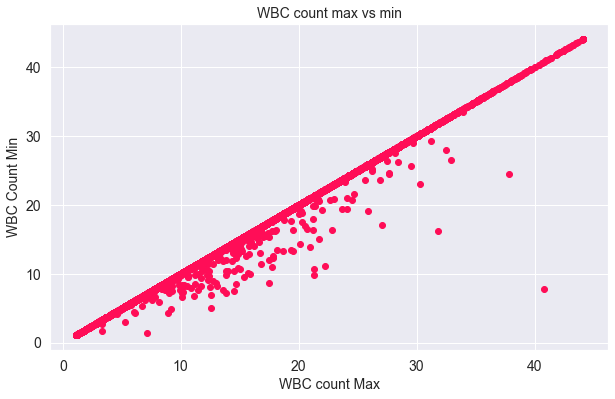

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(x = 'h1_wbc_max', y ='h1_wbc_min', data = df, color = '#FF0D57' )
plt.xlabel('WBC count Max', fontsize = 14)
plt.ylabel('WBC Count Min', fontsize = 14)
plt.title('WBC count max vs min', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [33]:
def drop_correlated_features(df):
    df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
    df1 = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
    cat_features = list(df1['Variable Name'].values)
    for c in cat_features:
        if c not in df1.columns or c == 'hospital_death':
            cat_features.remove(c)

    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()



    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
                    print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [34]:
drop_columns = drop_correlated_features(df)

col1: bilirubin_apache col2: d1_bilirubin_max - Correlation: 0.9965677029378415
col1: creatinine_apache col2: d1_creatinine_max - Correlation: 0.9938024247389716
col1: paco2_apache col2: paco2_for_ph_apache - Correlation: 1.0
col1: d1_diasbp_max col2: d1_diasbp_noninvasive_max - Correlation: 0.9978312339594645
col1: d1_diasbp_min col2: d1_diasbp_noninvasive_min - Correlation: 0.9968714632425789
col1: d1_mbp_min col2: d1_mbp_noninvasive_min - Correlation: 0.9955315558446697
col1: d1_sysbp_max col2: d1_sysbp_noninvasive_max - Correlation: 0.996559679816597
col1: d1_sysbp_min col2: d1_sysbp_noninvasive_min - Correlation: 0.9963220900474754
col1: h1_mbp_min col2: h1_mbp_noninvasive_min - Correlation: 0.9966727876843414
col1: h1_sysbp_max col2: h1_sysbp_noninvasive_max - Correlation: 0.9963772107865891
col1: d1_inr_max col2: h1_inr_max - Correlation: 1.0
col1: d1_inr_min col2: h1_inr_min - Correlation: 1.0
col1: h1_albumin_max col2: h1_albumin_min - Correlation: 0.9997274157107932
col1: h1_

In [35]:
drop_columns

array(['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max',
       'd1_bilirubin_max', 'd1_creatinine_max', 'h1_albumin_min',
       'h1_bilirubin_min', 'h1_bun_min', 'h1_creatinine_min',
       'h1_hco3_min', 'h1_inr_max', 'h1_inr_min', 'h1_platelets_min',
       'h1_wbc_min', 'diff_age', 'diff_height', 'diff_weight',
       'diff_albumin_apache', 'diff_arf_apache', 'diff_bilirubin_apache',
       'diff_bun_apache', 'diff_creatinine_apache', 'diff_fio2_apache',
       'diff_glucose_apache', 'diff_heart_rate_apache',
       'diff_hematocrit_apache', 'diff_intubated_apache',
       'diff_map_apache', 'diff_paco2_apache', 'diff_pao2_apache',
       'diff_ph_apache', 'diff_resprate_apache', 'diff_sodium_apache',
       'diff_temp_apache', 'diff_urineoutput_apache', 'diff_wbc_apache'],
      dtype=object)

In [36]:
features = [col for col in features if col not in drop_columns]

In [37]:
df = df[features]
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [38]:
df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})


binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']
# df['apache_3j_diagnosis']= df['apache_3j_diagnosis'].fillna(0).astype(np.int64)
df['apache_2_diagnosis']= df['apache_2_diagnosis'].fillna(0).astype(np.int64)
categorical.append('apache_2_diagnosis')
# categorical.append('apache_3j_diagnosis')

In [39]:
df.icu_type.value_counts()

Med-Surg ICU    50586
SICU             9822
CCT-CTICU        8779
MICU             7695
Neuro ICU        7675
CCU-CTICU        7156
Name: icu_type, dtype: int64

In [40]:
df.hospital_admit_source.value_counts()

Emergency Department    36962
Floor                    9965
Operating Room           9787
Direct Admit             6441
Recovery Room            2896
Other                    1648
SDU                      1176
PACU                     1017
ICU                       268
Chest Pain Center         134
Observation                10
Name: hospital_admit_source, dtype: int64

In [41]:
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_diagnosis',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'apache_2_diagnosis']

In [42]:
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
    df[col]= df[col].astype(np.int64).astype('category')

In [43]:
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [44]:
df.shape

(91713, 155)

In [45]:
df.hospital_death.value_counts()

1    83798
2     7915
Name: hospital_death, dtype: Int64

In [46]:
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary]

In [47]:
redundant_features = ['readmission_status', 'apache_2_bodysystem']

In [48]:
df.drop(columns = redundant_features, inplace = True)

In [49]:
numeric_col.remove('readmission_status')
numeric_col.remove('apache_2_diagnosis')
# numeric_col.remove('apache_3j_diagnosis')
# numeric_col.remove('log_bmi')
categorical.remove('apache_2_bodysystem')
categorical.remove('icu_stay_type')
categorical.remove('apache_2_diagnosis')
# categorical.remove('apache_3j_diagnosis')

In [50]:
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_3j_diagnosis',
 'apache_3j_bodysystem']

In [51]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'arterial_bp',
 'bool_h1_lactate_max']

In [52]:
df.shape

(91713, 153)

In [53]:
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [54]:
# create a empty dataframe (with NaNs)
train_ = pd.DataFrame(index=apache, columns= diagnosis)
train_.head(2)
# create a empty dataframe (with NaNs)
test_ = pd.DataFrame(index=apache, columns= diagnosis)
test_.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
for d in diagnosis:
    for a in apache:
        train_[d][a] = train[train.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        train['diff_'+ a] = np.where(train[a].notnull(), train_[d][a] - train[a], 0)

In [56]:
for d in diagnosis:
    for a in apache:
        test_[d][a] = test[test.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        test['diff_'+ a] = np.where(test[a].notnull(), test_[d][a] - test[a], 0)

In [57]:
features = [col for col in train.columns if col not in to_remove]
# redundant_features = ['readmission_status', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis'] + missing
# train.drop(columns = redundant_features, inplace = True)

In [58]:
train = train[features]
test = test[features]

In [59]:
# test.drop(columns = features, inplace = True)

In [60]:
numeric_col =[col for col in train.columns if  train[col].dtypes !='object' and col not in binary]

In [61]:
# numeric_col.remove('readmission_status')
# numeric_col.remove('apache_2_diagnosis')
# numeric_col.remove('apache_3j_diagnosis')
# categorical.remove('apache_2_bodysystem')
# categorical.remove('icu_stay_type')
# categorical.remove('apache_2_diagnosis')
# categorical.remove('apache_3j_diagnosis')
numeric_col.remove('hospital_id')
# categorical.append('hospital_id')

In [62]:
train.head(2)

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs,almost_dead,arterial_bp,bool_h1_lactate_max,diff_bmi,diff_age,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_ventilated_apache,diff_wbc_apache
59226,176,2,72.0,32.041330,1,Caucasian,F,154.9,SDU,Floor,admit,MICU,0.061111,76.88,2.0,113,501.02,1,1,2.4,26.0,1.64,NaN,4.0,6.0,1,4.0,107.0,99.0,27.9,1,45.0,NaN,NaN,NaN,13.0,135.0,36.6,NaN,1,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,2,Sepsis,14.0,1,1,1,-5.494076,-18.565217,13.202609,-1.656667,1.1,0.565217,-1.411111,16.913043,3.87,0.0,78.956522,-10.434783,0.204348,0.130435,65.217391,0.0,0.0,0.0,11.173913,2.956522,-0.146957,0.0,0.217391,-10.286087
81334,18,1,58.0,34.334291,1,Caucasian,M,190.5,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0.032639,124.60,2.5,113,501.01,1,1,1.2,70.0,2.85,NaN,1.0,1.0,1,1.0,319.0,138.0,37.4,1,47.0,NaN,NaN,NaN,53.0,117.0,36.2,NaN,2,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.8,37.4,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,1,1,1,1,1,Sepsis,3.0,1,1,1,-7.787036,-4.565217,-22.397391,-49.376667,0.6,0.565217,-0.211111,-27.086957,2.66,0.0,-133.043478,-49.434783,-9.295652,0.130435,63.217391,0.0,0.0,0.0,-28.826087,20.956522,0.253043,0.0,-0.782609,-3.676087


## Imputation
Imputation was done based on the type of variable it was. Broadly, there are numerical and categorical variables.

### Numerical variables

In [63]:
numeric_df = train[numeric_col]
numeric_df_test = test[numeric_col]
numeric_df.head(3)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs,diff_bmi,diff_age,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_ventilated_apache,diff_wbc_apache
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,113,2.4,26.0,1.64,NaN,4.0,6.0,4.0,107.0,99.0,27.9,45.0,NaN,NaN,NaN,13.0,135.0,36.60,NaN,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.70,35.80,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,-5.494076,-18.565217,13.202609,-1.656667,1.1,0.565217,-1.411111,16.913043,3.87,0.0,78.956522,-10.434783,0.204348,0.130435,65.217391,0.0,0.0,0.0,11.173913,2.956522,-0.146957,0.0,0.217391,-10.286087
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,113,1.2,70.0,2.85,NaN,1.0,1.0,1.0,319.0,138.0,37.4,47.0,NaN,NaN,NaN,53.0,117.0,36.20,NaN,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.80,36.20,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.80,37.40,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,-7.787036,-4.565217,-22.397391,-49.376667,0.6,0.565217,-0.211111,-27.086957,2.66,0.0,-133.043478,-49.434783,-9.295652,0.130435,63.217391,0.0,0.0,0.0,-28.826087,20.956522,0.253043,0.0,-0.782609,-3.676087
67173,78.0,32.764004,165.0,2.527083,89.20,NaN,218,NaN,NaN,NaN,NaN,3.0,6.0,5.0,NaN,41.0,NaN,63.0,NaN,NaN,NaN,12.0,NaN,36.33,NaN,NaN,108.0,44.0,70.0,44.0,116.0,63.0,20.0,12.0,98.0,91.0,149.0,104.0,37.22,36.33,85.0,64.0,53.0,50.0,85.0,85.0,18.0,13.0,97.0,97.0,138.0,125.0,37.22,36.44,NaN,NaN,NaN,12.0,12.0,NaN,NaN,0.56,115.0,115.0,23.0,23.0,13.7,13.7,40.7,40.7,NaN,NaN,NaN,NaN,164.0,164.0,4.4,4.4,141.0,141.0,7.59,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,-6.216749,-24.565217,3.102609,-13.976667,0.0,0.565217,0.000000,0.000000,0.00,0.0,0.000000,47.565217,0.000000,0.130435,47.217391,0.0,0.0,0.0,12.173913,0.000000,0.123043,0.0,0.217391,0.000000


In [64]:
binary_df = train[binary]
binary_df_test = test[binary]

binary_df.head(3)

,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,almost_dead,arterial_bp,bool_h1_lactate_max
59226,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1
81334,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1
67173,1,2,2,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1


In [65]:
categorical_df = train[categorical]
categorical_df_test = test[categorical]
categorical_df.isnull().sum()

ethnicity                 1123
gender                      19
hospital_admit_source    17227
icu_admit_source            92
icu_type                     0
apache_3j_diagnosis          0
apache_3j_bodysystem      1346
dtype: int64

In [66]:
# from sklearn.experimental import enable_iterative_imputer  
# from sklearn.impute import IterativeImputer
# # from sklearn.impute import KNNImputer


In [67]:
# imp = IterativeImputer(max_iter=3, verbose=0)
# imp.fit(numeric_df)
# imputed_df = imp.transform(numeric_df)
# imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns, index = numeric_df.index)

In [68]:
# impt = IterativeImputer(max_iter=3, verbose=0)
# impt.fit(numeric_df_test)
# imputed_df_test = impt.transform(numeric_df_test)
# imputed_df_test = pd.DataFrame(imputed_df_test, columns=numeric_df_test.columns, index = numeric_df_test.index)

In [69]:
for col in categorical:
    categorical_df[col].fillna(categorical_df[col].mode()[0],inplace=True)

In [70]:
for col in categorical:
    categorical_df_test[col].fillna(categorical_df_test[col].mode()[0],inplace=True)

In [71]:
# imputed_df.head(2)

In [72]:
# imputed_df.shape, imputed_df_test.shape

In [73]:
# scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df)

# numeric_df_scaled = pd.DataFrame(scaler.transform(numeric_df), columns=numeric_df.columns.values).set_index([numeric_df.index.values])


In [74]:
# numeric_df_scaled

In [75]:
# scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df)

# imputed_df_scaled = pd.DataFrame(scaler.transform(imputed_df), columns=imputed_df.columns.values).set_index([imputed_df.index.values])


scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df)


numeric_df_scaled = pd.DataFrame(scaler.transform(numeric_df), columns=numeric_df.columns.values).set_index([numeric_df.index.values])




In [76]:
# scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df_test)

# imputed_df_test_scaled = pd.DataFrame(scaler1.transform(imputed_df_test), columns=imputed_df_test.columns.values).set_index([imputed_df_test.index.values])

scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df_test)

numeric_df_test_scaled = pd.DataFrame(scaler1.transform(numeric_df_test), columns=numeric_df_test.columns.values).set_index([numeric_df_test.index.values])



In [77]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 117), (73370, 7), (73370, 18))

# Encoding

## Label encoding


In [78]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'arterial_bp',
 'bool_h1_lactate_max']

In [79]:
categorical_df.dtypes

ethnicity                object
gender                   object
hospital_admit_source    object
icu_admit_source         object
icu_type                 object
apache_3j_diagnosis      object
apache_3j_bodysystem     object
dtype: object

In [80]:
categorical_df.apache_3j_bodysystem.value_counts()

Cardiovascular          25284
Neurological             9576
Sepsis                   9395
Respiratory              9283
Gastrointestinal         7220
Metabolic                6101
Trauma                   3084
Genitourinary            1740
Musculoskeletal/Skin      936
Hematological             503
Gynecological             248
Name: apache_3j_bodysystem, dtype: int64

## One hot encoding

In [81]:
from sklearn.preprocessing import OneHotEncoder

In [82]:
categorical_df.columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_type', 'apache_3j_diagnosis', 'apache_3j_bodysystem'],
      dtype='object')

In [83]:
binary_df.drop(columns=['hospital_death'], inplace = True)
binary_df_test.drop(columns=['hospital_death'], inplace = True)

In [84]:
l = ['ethnicity','gender','hospital_admit_source', 'icu_admit_source','icu_type', 'apache_3j_bodysystem',
 'apache_3j_diagnosis',
     'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [85]:
train1 = pd.concat([categorical_df, binary_df], axis =1)
test1 = pd.concat([categorical_df_test, binary_df_test], axis =1)

In [86]:
# train['apache_3j_diagnosis'] = train1['apache_3j_diagnosis'].astype(str)
train1.head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type,apache_3j_diagnosis,apache_3j_bodysystem,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,almost_dead,arterial_bp,bool_h1_lactate_max
59226,Caucasian,F,SDU,Floor,MICU,501.02,Sepsis,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1
81334,Caucasian,M,Direct Admit,Accident & Emergency,Med-Surg ICU,501.01,Sepsis,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1


In [87]:
train1.apache_3j_diagnosis = train1.apache_3j_diagnosis.astype(str)
test1.apache_3j_diagnosis = test1.apache_3j_diagnosis.astype(str)

In [88]:
train1 = prepare_ravinder.encode(train1, l)
test1 = prepare_ravinder.encode(test1, l)

In [89]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 117), (73370, 7), (73370, 17))

In [90]:
# imputed_df.shape, categorical_df.shape, binary_df.shape

In [91]:
# train = pd.concat([imputed_df_scaled ,train1], axis =1)
# test = pd.concat([imputed_df_test_scaled ,test1], axis =1)

train = pd.concat([numeric_df_scaled ,train1], axis =1)
test = pd.concat([numeric_df_test_scaled ,test1], axis =1)



# train

# Modeling

## Baseline

In [186]:
df = pd.read_csv('data/training_v2.csv')
df = df[df['apache_4a_icu_death_prob'].notna()]

train_b, test_b = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [187]:
y_test_b = test_b[['hospital_death']]
y_train_b = train_b[['hospital_death']]

In [188]:
y_train_b.shape

(67012, 1)

In [189]:
y_pred1 = train_b[['apache_4a_icu_death_prob']]

In [190]:
# y_pred = np.zeros(73370)

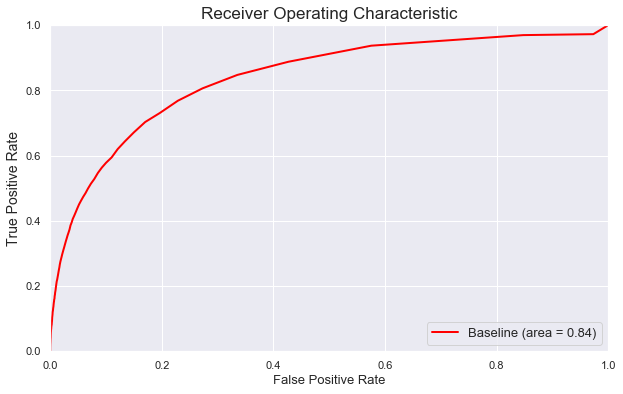

In [193]:
plt.figure(figsize=(10,6))

# y_pred = clf.predict(X)
fpr, tpr, thresholds = roc_curve(y_train_b, y_pred1)
plt.plot(fpr, tpr, color='red', lw=2, label='Baseline (area = %0.2f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

<Figure size 432x288 with 0 Axes>

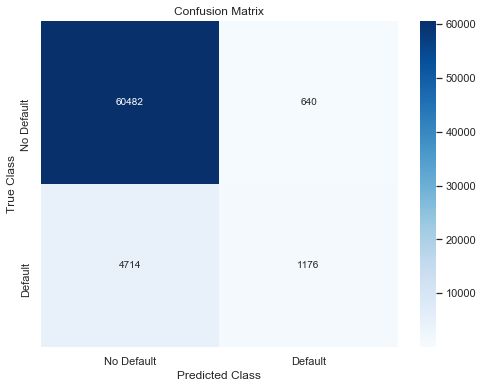

In [182]:
# y_pred = np.where(y_pred > 0.5, 1, 0)
plt.figure()
cm = confusion_matrix(y_train_b, y_pred)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Logist regression

### Building a Model

In [264]:
# from sklearn.linear_model import LogisticRegression

In [265]:
# param = ['height',
#  'temp_apache',
#  'd1_diasbp_max',
#  'd1_diasbp_min',
#  'd1_heartrate_max',
#  'd1_heartrate_min',
#  'd1_mbp_max',
#  'd1_mbp_min',
#  'd1_spo2_max',
#  'd1_spo2_min',
#  'd1_sysbp_max',
#  'd1_sysbp_min',
#  'd1_temp_max',
#  'd1_temp_min']
# for p in param:  
#     complet_df['bool_'+ p] = np.where(pd.notnull(complet_df[p]), 1,0)

In [92]:
train2, test2 = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [93]:
y = train2[['hospital_death']]
y['hospital_death'] = y['hospital_death']-1
X = train

y_test = test2[['hospital_death']]
y_test['hospital_death'] = y_test['hospital_death']-1
X_test = test

In [94]:
y['hospital_death'] = y['hospital_death'].astype(int)
y_test['hospital_death'] = y_test['hospital_death'].astype(int)

In [95]:
X.shape, y.shape

((73370, 301), (73370, 1))

In [96]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import svm
# # pipe = Pipeline([('classifier')])
# # pipe = Pipeline([('classifier', RandomForestClassifier())])

# # Create param grid.
# logistic = LogisticRegression()

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-2, 2, 20),
#     'classifier__solver' : ['liblinear']}
# ]

# # Create grid search object

# clf = GridSearchCV('logistic', param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(X, y)

In [98]:
# logit = LogisticRegression(C = 100.0, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
# logit.fit(X, y)

In [99]:
# y_pred = logit.predict(X)

In [100]:
# y_pred_test = logit.predict(X_test)

In [247]:
# feature_imp = pd.DataFrame(logit.coef_[0], index = X.columns).reset_index()

In [248]:
# feature_imp.columns = ['feature', 'coeff']
# feature_imp.sort_values('coeff').head(199)

In [249]:
# feature_imp.to_csv('data/feature_imp.csv')

### AUC Roc score

In [250]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [251]:
# plt.figure(figsize=(10,6))

# y_pred_test = logit.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         


# # y_pred = knn.predict_proba(X_validate_scaled)[:,1]
# # fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# # plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


# # y_pred_test = rf.predict_proba(X_test)[:,1]
# # fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
# # plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [252]:
# idx = []
# for i in range(101, 183):
#     idx.append(i)

In [253]:
# sm = SMOTENC(random_state=42, categorical_features = idx)
# x_train_res, y_train_res = sm.fit_sample(X, y)
# print (Y_train.value_counts() , np.bincount(y_train_res))

In [254]:
# logit = LogisticRegression(C = .01, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
# logit.fit(x_train_res, y_train_res)

In [255]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(x_train_res)[:,1]
# fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [256]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

## Decision Tree

### Building a model

In [257]:
# from sklearn.tree import DecisionTreeClassifier


In [258]:
# dt = DecisionTreeClassifier(max_depth=8, random_state=42, class_weight={1:2})
# dt.fit(X, y)

In [259]:
# rf = RandomForestClassifier(bootstrap=True, 
#                             class_weight= "balanced" , 
#                             criterion='gini',
#                             min_samples_leaf=10,
#                             n_estimators=100,
#                             max_depth=8, 
#                             random_state=123)

In [260]:
# rf.fit(X, y)

In [261]:
# plt.figure(figsize=(10,6))

# y_pred = rf.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='RF Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [262]:
# plt.figure(figsize=(10,6))

# y_pred = rf.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='RF Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [270]:
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [97]:
X['almost_dead'] = X['almost_dead'].astype(np.float64)
X['bool_h1_lactate_max'] = X['bool_h1_lactate_max'].astype(np.float64)
X_test['almost_dead'] = X_test['almost_dead'].astype(np.float64)
X_test['bool_h1_lactate_max'] = X_test['bool_h1_lactate_max'].astype(np.float64)
X['arterial_bp'] = X['arterial_bp'].astype(np.float64)
X_test['arterial_bp'] = X_test['arterial_bp'].astype(np.float64)


In [265]:
# def modelfit(alg, dtrain, y ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X.values, label= y.values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(X, y['hospital_death'],eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(X)
#     dtrain_predprob = alg.predict_proba(X)[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(y['hospital_death'].values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(y['hospital_death'], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [266]:
# sorted_idx = np.argsort(model.feature_importances_)[::-1]
# f_imp = []
# for index in sorted_idx:
#     f_imp.append([X.columns[index], model.feature_importances_[index]]) 

In [267]:
# predictors = [x for x in X.columns]
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# modelfit(xgb1, X, y)

In [268]:
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed= 42)
# modelfit(xgb1, X, y)

In [269]:
# param_test1 = {
#  'max_depth':range(5,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=172, max_depth=7,
#  min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(X,y)
# gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [270]:
# param_test2 = {
#  'max_depth':[4,5,6],
#  'min_child_weight':[1,2,3]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch2.fit(X,y)
# gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [271]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
#  min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch3.fit(X,y)
# gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [272]:
# param_test4 = {
#  'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=7,
#  min_child_weight=5, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch4.fit(X,y)
# gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [273]:
# X.columns.to_list()

In [525]:
model = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha=0.0001, seed=27)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=177, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [528]:
y_pred = model.predict(X)

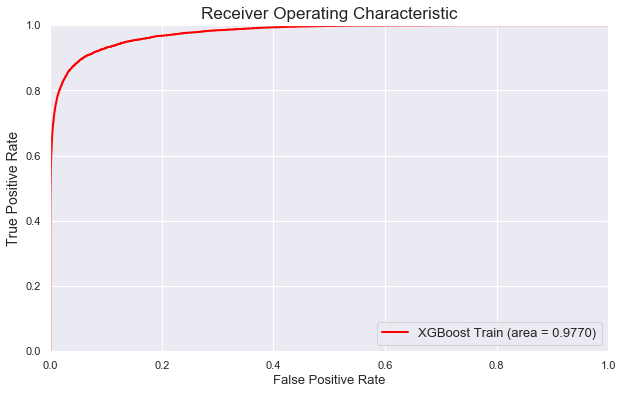

In [529]:
plt.figure(figsize=(10,6))

y_pred = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [277]:
X.shape

(73370, 301)

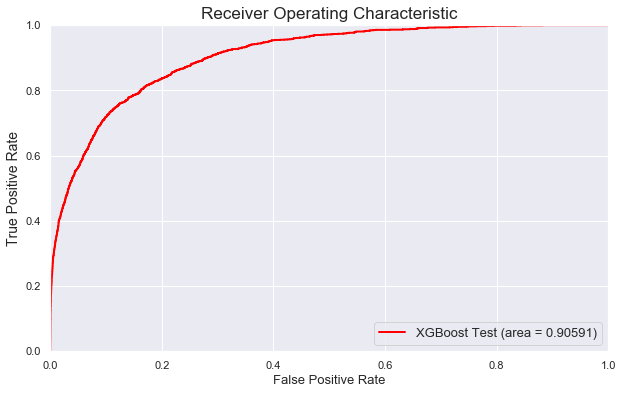

In [530]:
plt.figure(figsize=(10,6))

y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Test (area = %0.5f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [279]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
f_imp = []
for index in sorted_idx:
    f_imp.append([X.columns[index], model.feature_importances_[index]]) 


In [280]:
feature_importance = pd.DataFrame(f_imp)
feature_importance.columns = ['feature', 'importance']
zero_imp = list(feature_importance[feature_importance.importance <0.0001].feature.values)

In [400]:
# zero_imp

In [282]:
feature_importance.head(25)

,feature,importance
0,almost_dead,0.241711
1,diff_ventilated_apache,0.043120
2,elective_surgery_2,0.033704
3,ventilated_apache_1,0.026885
4,apache_3j_diagnosis_102.01,0.022518
5,elective_surgery_1,0.018819
6,gcs_verbal_apache,0.017136
7,gcs,0.015306
8,gcs_motor_apache,0.014364
9,d1_lactate_min,0.013618


In [283]:

# X = X.drop(columns = zero_imp)
# X_test = X_test.drop(columns = zero_imp)

In [284]:
# from numpy import sort
# thresholds = sort(model.feature_importances_)
# thresholds

In [285]:
# plt.figure(figsize=(10,6))

# y_pred = model.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [286]:
# plt.figure(figsize=(10,6))

# y_pred = model_ad.predict_proba(x_train_res)[:,1]
# fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [287]:
# plt.figure(figsize=(10,6))

# y_pred = model_ad.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [288]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# # pprint(random_grid)

In [289]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(random_state = 42)
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X, y)

In [290]:

# from keras.models import Sequential
# from keras.layers import Dense
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.models import Model

In [291]:
# model = Sequential()
# model.add(Dense(12, input_dim=201, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [292]:
# METRICS = [keras.metrics.AUC(name='auc')]
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[METRICS])

In [293]:
# model.fit(X, y, epochs=100, batch_size=64)

In [294]:
# y_pred = model.predict(X)
# y_pred

In [295]:
# plt.figure(figsize=(10,6))

# # y_pred = model.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [296]:
# y_pred = model.predict(X_test)

In [297]:
# plt.figure(figsize=(10,6))

# # y_pred = model.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [531]:
# pd.Series(selected_features).to_csv('selected_features.csv')

In [101]:
selected_features = pd.read_csv('selected_features.csv')
selected_features = list(selected_features['0'])

In [102]:
X = X[selected_features]
X_test = X_test[selected_features]

In [98]:

from lightgbm import LGBMClassifier

In [136]:
import lightgbm as lgb
d_train = lgb.Dataset(X, label=y)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 6
params['min_child_weight'] = 1
params['n_estimators'] = 350
clf = lgb.train(params, d_train, 350)

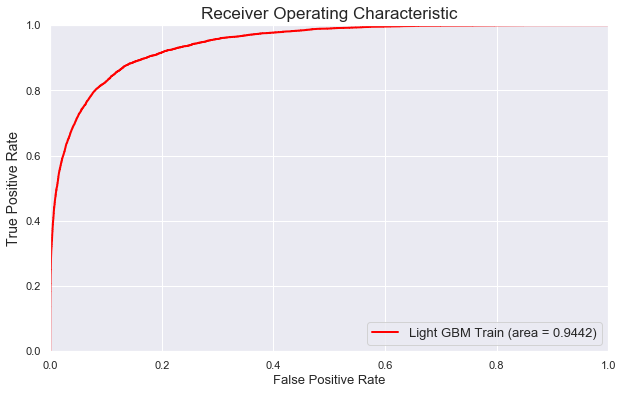

In [137]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

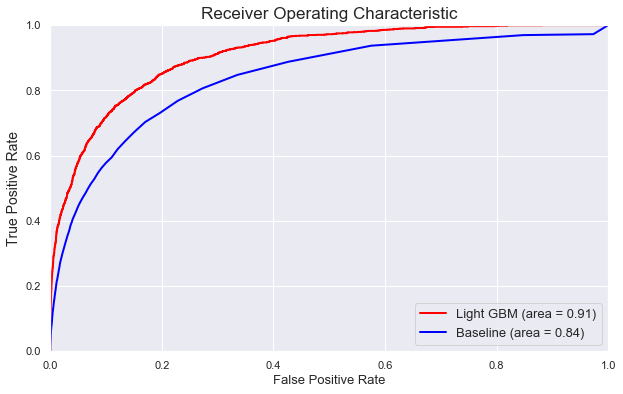

In [196]:
plt.figure(figsize=(10,6))

y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM (area = %0.2f)' % auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_train_b, y_pred1)
plt.plot(fpr, tpr, color='blue', lw=2, label='Baseline (area = %0.2f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [102]:
from lightgbm import plot_tree
from lightgbm import create_tree_digraph
from lightgbm import plot_importance

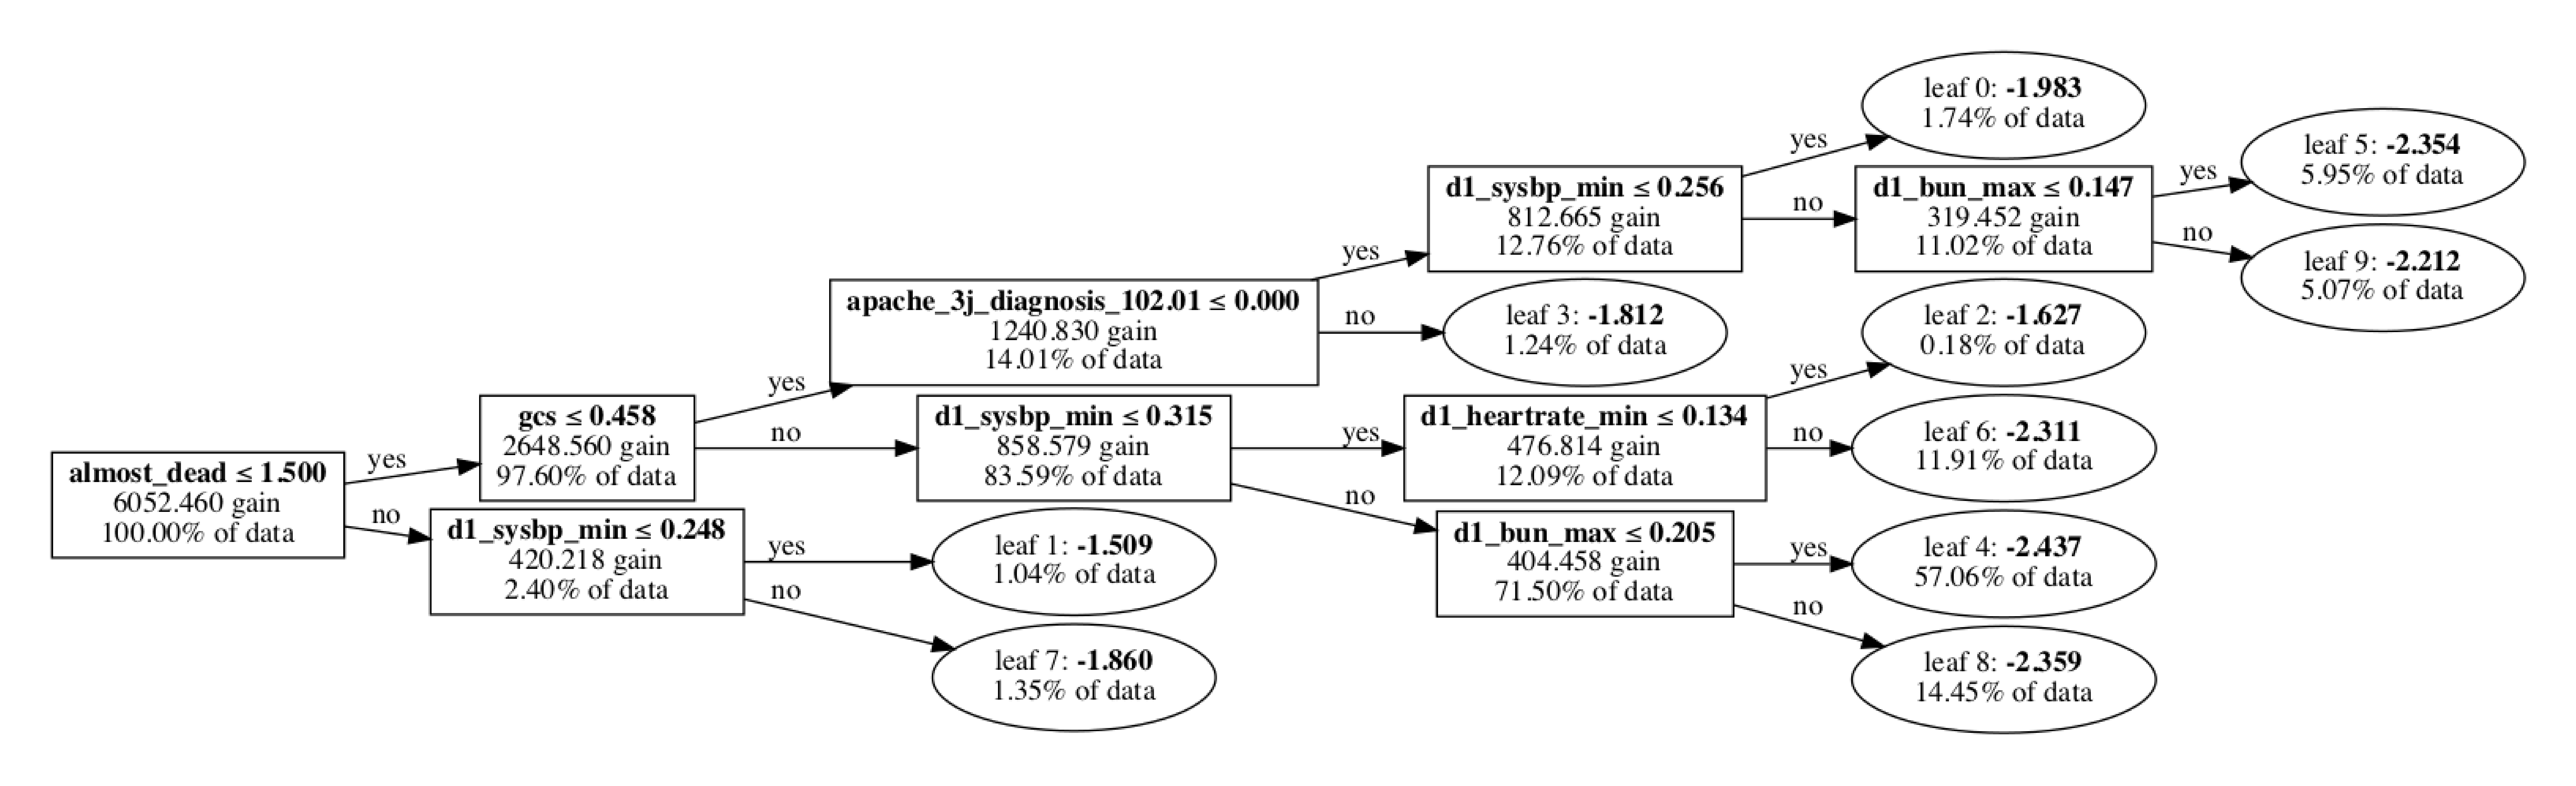

In [454]:
# plot single tree
fig = plt.figure(dpi=1800)
ax = plt.subplot(1,1,1)
plot_tree(clf, ax = ax, show_info = ['split_gain', 'data_percentage'])
plt.tight_layout()
# plt.savefig('lgm_tree.png')
plt.show()

In [457]:
# fig = plt.figure(dpi=1800)
# ax = plt.subplot(1,1,1)
# create_tree_digraph(clf)
# plt.tight_layout()
# plt.show()


In [121]:
# for col in binary:
#     train[col]= train[col]-1
#     train[col].fillna(0,inplace=True)
#     train[col]= train[col].astype(int)

In [124]:
# y = train[['hospital_death']]
# train = train.drop(columns = ['hospital_death'])

In [103]:
categorical_feats = [
    f for f in X.columns if X[f].dtype == 'object'
]

categorical_feats 
for f_ in categorical_feats:
    X[f_], _ = pd.factorize(X[f_])
    # Set feature type as categorical
    X[f_] = X[f_].astype('category')

In [104]:
categorical_feats

[]

In [105]:
def get_feature_importances(data, shuffle,y, seed=None):
    # Gather real features
    train_features = [f for f in data]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
#     y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = y['hospital_death'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(train[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')

    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [106]:
# Seed the unexpected randomness of this world
np.random.seed(42)
# imp_df = pd.DataFrame()
# imp_df["feature"] = list(df.columns)
# imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
# imp_df["importance_split"] = clf.feature_importance(importance_type='split')

# imp_df['trn_score'] = roc_auc_score(y, clf.predict(df))
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=X, y = y,shuffle=False)
# actual_imp_df = imp_df

In [107]:
actual_imp_df

,feature,importance_gain,importance_split,trn_score
0,age,37733.933909,1026,0.89804
1,bmi,9911.683137,326,0.89804
2,height,2481.041686,124,0.89804
3,pre_icu_los_days,11360.136663,295,0.89804
4,weight,5480.644587,173,0.89804
...,...,...,...,...
296,lymphoma_1,28.916300,1,0.89804
297,lymphoma_2,0.000000,0,0.89804
298,solid_tumor_with_metastasis_0,0.000000,0,0.89804
299,solid_tumor_with_metastasis_1,1129.979603,34,0.89804


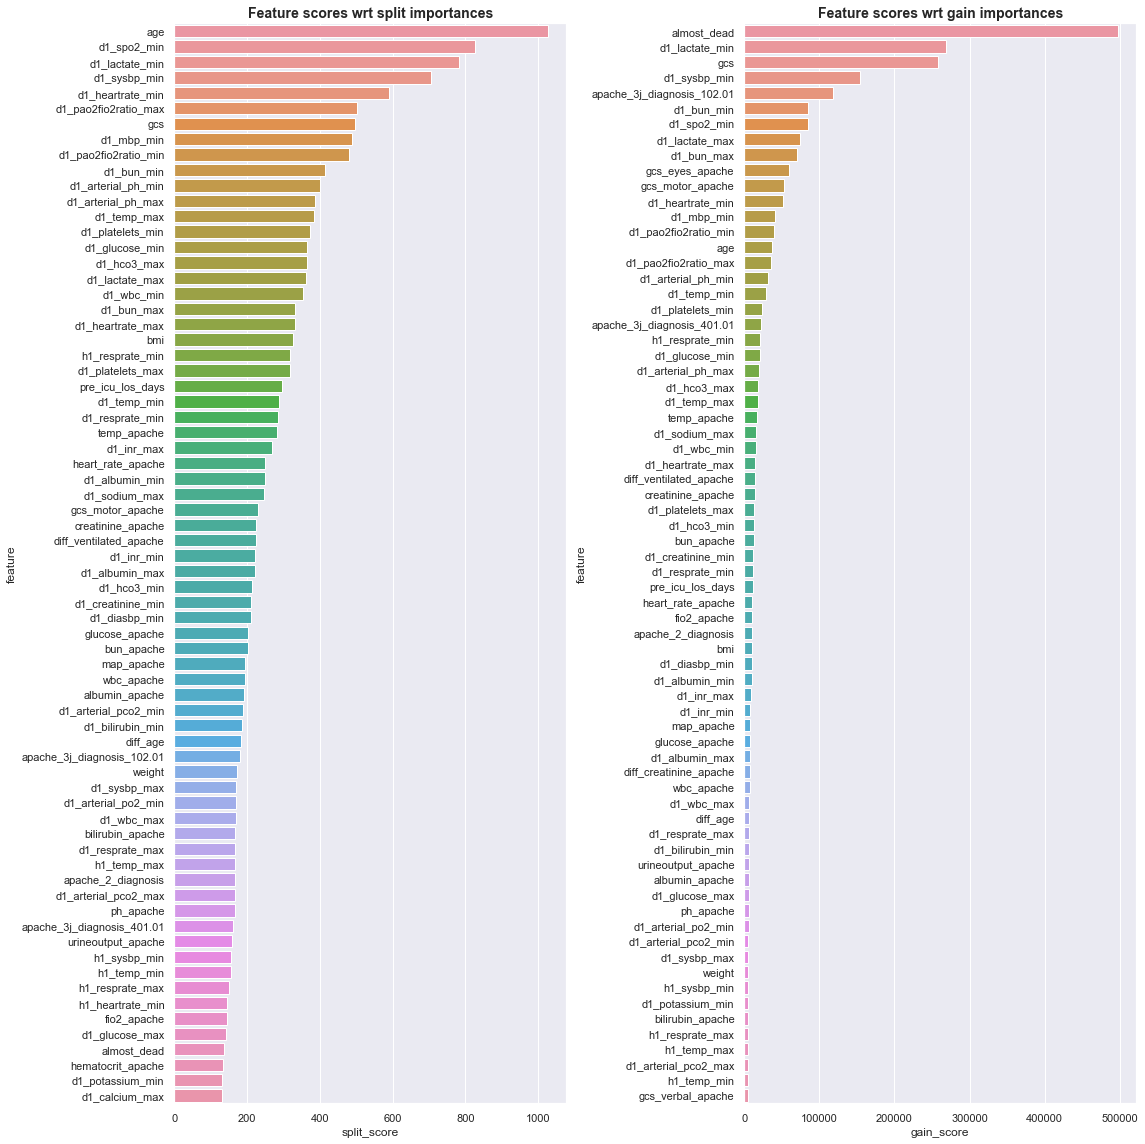

In [108]:
# Use the log actual feature importance divided by the 75 percentile of null distribution
feature_scores = []
for _f in actual_imp_df['feature'].unique():
#     f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = f_act_imps_gain  # Avoid didvide by zero
#     f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score =  f_act_imps_split  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))
#     print(f' f= {_f},null percentile: {np.percentile(f_null_imps_gain, 75)}, actual gain: {f_act_imps_gain}')

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [109]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, y = y, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  14.3 min)

In [110]:
null_imp_df.head(5)

,feature,importance_gain,importance_split,trn_score,run
0,age,2822.270033,620,0.836085,1
1,bmi,2539.374354,376,0.836085,1
2,height,2455.591274,265,0.836085,1
3,pre_icu_los_days,2193.255319,224,0.836085,1
4,weight,2470.259823,231,0.836085,1


In [111]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances',color = '#1E88E5')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color= '#FF0D57',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances',color = '#1E88E5')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color= '#FF0D57',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

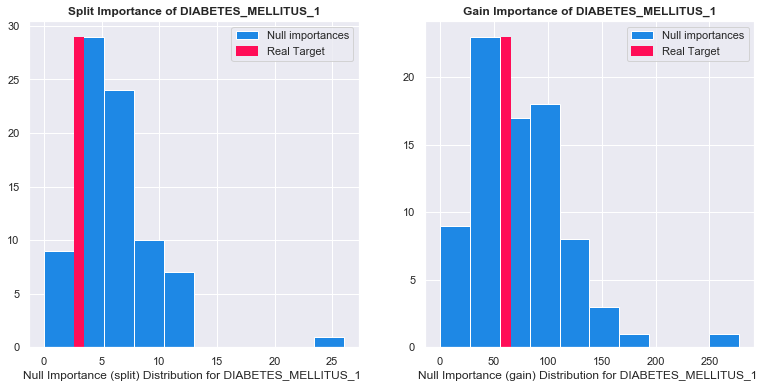

In [351]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='diabetes_mellitus_1')

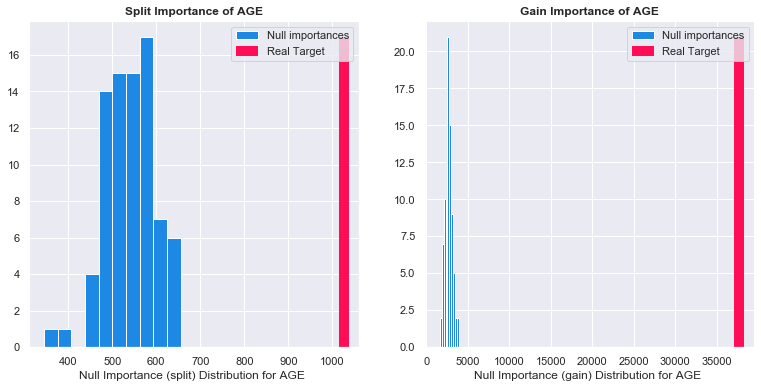

In [352]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='age')

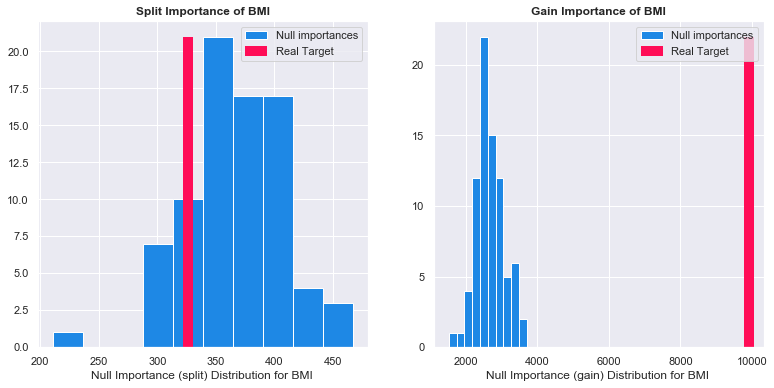

In [353]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='bmi')

In [112]:
scores_df.sort_values('split_score', ascending=False).head(20)

,feature,split_score,gain_score
0,age,1026.0,37733.933909
35,d1_spo2_min,826.0,84357.930857
73,d1_lactate_min,782.0,268465.880734
37,d1_sysbp_min,705.0,154371.642863
29,d1_heartrate_min,591.0,51723.416769
90,d1_pao2fio2ratio_max,501.0,36026.692055
92,gcs,498.0,258055.140316
31,d1_mbp_min,489.0,41545.508317
91,d1_pao2fio2ratio_min,481.0,39665.648092
58,d1_bun_min,415.0,85423.954617


In [115]:
scores_df.to_csv('scores_df.csv')

In [113]:
scores_df.iloc[162,0] = 'Cardiac arrest'
scores_df.iloc[232,0] = 'Intracrnial haemorrhage'
scores_df.iloc[115,0] = 'diff_ventilated'
scores_df.iloc[275,0] = 'Ventilated'
scores_df.iloc[235,0] = 'Cerebrovascular accident/stroke'
# scores_df.iloc[92,0] = ''
# scores_df.iloc[12,0]
# scores_df.iloc[299,0]
# scores_df.iloc[264,0]
# scores_df.iloc[157,0]
# scores_df.iloc[276,0]
# scores_df.iloc[73,0]
# scores_df.iloc[265,0]
# scores_df.iloc[262,0]
# scores_df.iloc[35,0]
# scores_df.iloc[140,0]
# scores_df.iloc[37,0]

# scores_df.iloc[91,0]

# scores_df.iloc[122,0]


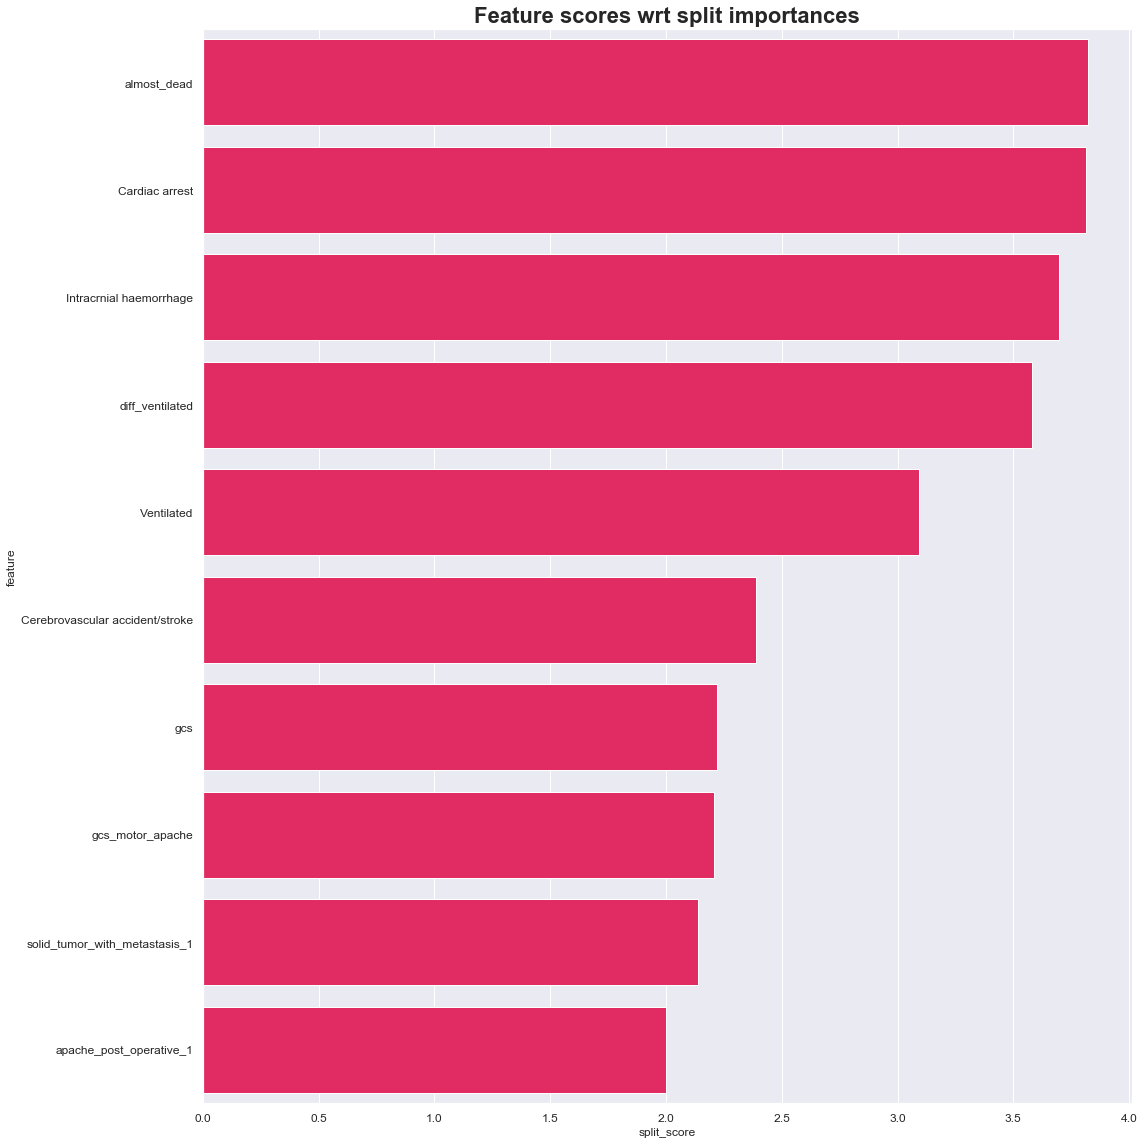

In [114]:
# Use the log actual feature importance divided by the 75 percentile of null distribution
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))
#     print(f' f= {_f},null percentile: {np.percentile(f_null_imps_gain, 75)}, actual gain: {f_act_imps_gain}')

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

scores_df.iloc[162,0] = 'Cardiac arrest'
scores_df.iloc[232,0] = 'Intracrnial haemorrhage'
scores_df.iloc[115,0] = 'diff_ventilated'
scores_df.iloc[275,0] = 'Ventilated'
scores_df.iloc[235,0] = 'Cerebrovascular accident/stroke'

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 1)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:10], ax=ax, color = '#FF0D57')
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=22)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.xlabel('feature', fontsize = 14)
# Plot Gain importances
# ax = plt.subplot(gs[0, 1])
# sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:25], ax=ax)
# ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=16)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# # plt.xlabel('Features', fontsize = 14)
# # plt.ylabel(fontsize = 14)

plt.tight_layout()

In [302]:
# Save data
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

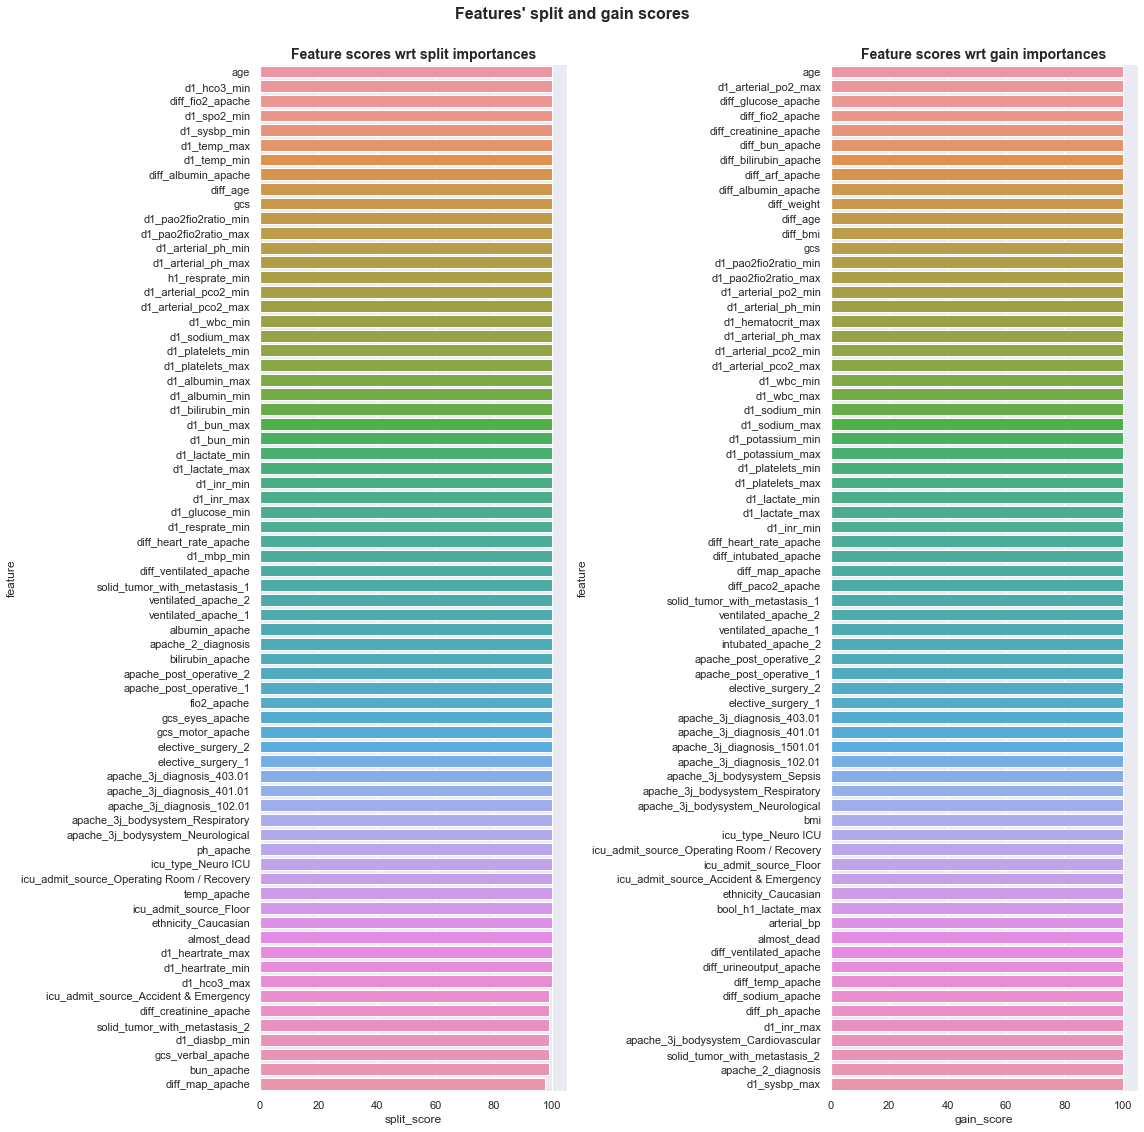

In [303]:
#Check the impact of removing uncorrelated features
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
#     print(f'{_f}: {f_act_imps}')
#     print((f_null_imps < np.percentile(f_act_imps, 0)).sum())
#     print(f_null_imps.size)
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 0)).sum() / f_null_imps.size
#     print(gain_score)
#     print('-------------')
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [512]:
split_feats = [_f for _f, _score, _ in correlation_scores if _score > 0]
gain_feats = [_f for _f, _, _score in correlation_scores if _score > 0]


In [513]:
len(split_feats)

173

In [514]:
len(gain_feats)

180

In [515]:
selected_features =  list(np.unique(split_feats + gain_feats))

In [460]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=42
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    print(split_cat_feats)
    print(gain_cat_feats)
    split_results = score_feature_selection(df=train, train_features=split_feats, cat_feats=split_cat_feats, target= y['hospital_death'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=train, train_features=gain_feats, cat_feats=gain_cat_feats, target= y['hospital_death'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
[]
[]
	 SPLIT : 0.900950 +/- 0.002495
	 GAIN  : 0.900950 +/- 0.002495
Results for threshold  10
[]
[]


KeyboardInterrupt: 

In [106]:
corr_scores_df

,feature,split_score,gain_score
0,hospital_id,0.0,95.0
1,age,100.0,100.0
2,bmi,7.5,100.0
3,elective_surgery,90.0,100.0
4,ethnicity,0.0,0.0
...,...,...,...
139,diff_resprate_apache,0.0,95.0
140,diff_sodium_apache,0.0,62.5
141,diff_temp_apache,17.5,100.0
142,diff_urineoutput_apache,0.0,90.0


In [ ]:
# import lightgbm as lgb
# d_train = lgb.Dataset(X, label=y)
# params = {}
# params['learning_rate'] = 0.1
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'binary'
# params['metric'] = 'binary_logloss'
# params['sub_feature'] = 0.5
# params['num_leaves'] = 10
# params['min_data'] = 50
# params['max_depth'] = 6
# params['min_child_weight'] = 1
# params['n_estimators'] = 350
# clf = lgb.train(params, d_train, 350)

In [356]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [353]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 30), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [354]:
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=42, silent=True, metric='None', n_jobs=4, n_estimators=400)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state= 42,
    verbose=True)

In [357]:
gs.fit(X, y, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.902766
[200]	valid's auc: 0.90722
[300]	valid's auc: 0.907972
Early stopping, best iteration is:
[293]	valid's auc: 0.908038
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.903534
[200]	valid's auc: 0.906053
Early stopping, best iteration is:
[219]	valid's auc: 0.906262
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.901828
[200]	valid's auc: 0.905199
[300]	valid's auc: 0.905387
Early stopping, best iteration is:
[271]	valid's auc: 0.905467
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.893415
[200]	valid's auc: 0.898842
[300]	valid's auc: 0.900717
Early stopping, best iteration is:
[288]	valid's auc: 0.900726
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.894849
[200]	valid's auc: 0.8999
[300]	valid's auc: 0.901889
Early stopping, best iteration is:
[330]	valid's auc: 

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.902278
[200]	valid's auc: 0.905711
[300]	valid's auc: 0.906382
[400]	valid's auc: 0.906956
Did not meet early stopping. Best iteration is:
[390]	valid's auc: 0.907073
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.903235
[200]	valid's auc: 0.90524
Early stopping, best iteration is:
[231]	valid's auc: 0.905701
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.901573
[200]	valid's auc: 0.904254
[300]	valid's auc: 0.905203
Early stopping, best iteration is:
[313]	valid's auc: 0.905319
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.891778
Early stopping, best iteration is:
[143]	valid's auc: 0.894035
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.892407
Early stopping, best iteration is:
[159]	valid's auc: 0.894754
Training until validation scores don't improve for 30 rounds

[100]	valid's auc: 0.902658
Early stopping, best iteration is:
[96]	valid's auc: 0.902836
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.899151
[200]	valid's auc: 0.904246
[300]	valid's auc: 0.905527
[400]	valid's auc: 0.906606
Did not meet early stopping. Best iteration is:
[399]	valid's auc: 0.906623
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.900637
[200]	valid's auc: 0.905519
[300]	valid's auc: 0.90684
[400]	valid's auc: 0.907354
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.907354
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.900223
[200]	valid's auc: 0.905068
[300]	valid's auc: 0.906538
[400]	valid's auc: 0.906889
Did not meet early stopping. Best iteration is:
[373]	valid's auc: 0.907046
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.871789
[200]	valid's auc: 0.877233
[300]	valid's auc: 0.878748
[400]	valid's auc: 

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.901561
[200]	valid's auc: 0.904193
Early stopping, best iteration is:
[231]	valid's auc: 0.904586
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.872118
[200]	valid's auc: 0.877493
[300]	valid's auc: 0.879056
[400]	valid's auc: 0.879937
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.879937
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.873335
[200]	valid's auc: 0.878759
[300]	valid's auc: 0.880421
[400]	valid's auc: 0.881136
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.881136
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.873359
[200]	valid's auc: 0.878132
[300]	valid's auc: 0.879739
[400]	valid's auc: 0.880617
Did not meet early stopping. Best iteration is:
[399]	valid's auc: 0.880619
Training until validation scores don't improve for 30 rounds
[100]	valid'

[100]	valid's auc: 0.904124
[200]	valid's auc: 0.907039
[300]	valid's auc: 0.907711
Early stopping, best iteration is:
[272]	valid's auc: 0.907888
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.904148
[200]	valid's auc: 0.906695
Early stopping, best iteration is:
[232]	valid's auc: 0.907235
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.904011
[200]	valid's auc: 0.9053
Early stopping, best iteration is:
[177]	valid's auc: 0.905448
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.872348
[200]	valid's auc: 0.877456
[300]	valid's auc: 0.878985
[400]	valid's auc: 0.879866
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.879866
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.873043
[200]	valid's auc: 0.878084
[300]	valid's auc: 0.879719
[400]	valid's auc: 0.880488
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.8804

Early stopping, best iteration is:
[152]	valid's auc: 0.906496
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.905031
Early stopping, best iteration is:
[126]	valid's auc: 0.905767
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.897086
[200]	valid's auc: 0.900562
Early stopping, best iteration is:
[197]	valid's auc: 0.900563
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.898484
[200]	valid's auc: 0.902085
[300]	valid's auc: 0.902294
Early stopping, best iteration is:
[273]	valid's auc: 0.902294
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.896824
[200]	valid's auc: 0.900082
[300]	valid's auc: 0.900203
Early stopping, best iteration is:
[323]	valid's auc: 0.900203
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.889287
Early stopping, best iteration is:
[147]	valid's auc: 0.892203
Training until validation scores don'

[100]	valid's auc: 0.899384
Early stopping, best iteration is:
[166]	valid's auc: 0.901928
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.899333
[200]	valid's auc: 0.900676
Early stopping, best iteration is:
[197]	valid's auc: 0.900676
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.889004
[200]	valid's auc: 0.891749
Early stopping, best iteration is:
[192]	valid's auc: 0.89175
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.891695
[200]	valid's auc: 0.895037
Early stopping, best iteration is:
[216]	valid's auc: 0.895038
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.889488
[200]	valid's auc: 0.8922
Early stopping, best iteration is:
[217]	valid's auc: 0.8922
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.901087
[200]	valid's auc: 0.904504
Early stopping, best iteration is:
[213]	valid's auc: 0.904812
Training until

[200]	valid's auc: 0.876774
[300]	valid's auc: 0.878255
[400]	valid's auc: 0.879263
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.879263
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.87276
[200]	valid's auc: 0.878444
[300]	valid's auc: 0.880005
[400]	valid's auc: 0.880911
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.880911
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.871691
[200]	valid's auc: 0.877395
[300]	valid's auc: 0.879207
[400]	valid's auc: 0.880058
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.880058


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 27.4min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.901971
[200]	valid's auc: 0.906131
[300]	valid's auc: 0.908017
[400]	valid's auc: 0.908883
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.908883
Best score reached: 0.9021753059138868 with params: {'colsample_bytree': 0.4198304397403291, 'min_child_samples': 323, 'min_child_weight': 0.01, 'num_leaves': 6, 'reg_alpha': 1, 'reg_lambda': 20, 'subsample': 0.3159158976729785} 


 Best score reached: 0.9028386449352278 with params: {'colsample_bytree': 0.5284213741879101, 'min_child_samples': 125, 'min_child_weight': 10.0, 'num_leaves': 22, 'reg_alpha': 0.1, 'reg_lambda': 20, 'subsample': 0.3080033455431848} 

In [358]:
opt_parameters = {'colsample_bytree': 0.4198304397403291, 'min_child_samples': 323, 'min_child_weight': 0.01, 'num_leaves': 6, 'reg_alpha': 1, 'reg_lambda': 20, 'subsample': 0.3159158976729785} 

In [359]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.4198304397403291, metric='None',
               min_child_samples=323, min_child_weight=0.01, n_estimators=400,
               n_jobs=4, num_leaves=6, random_state=42, reg_alpha=1,
               reg_lambda=20, subsample=0.3159158976729785)

In [360]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [361]:
gs_sample_weight.fit(X, y, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.900238
[200]	valid's auc: 0.905208
[300]	valid's auc: 0.90737
Early stopping, best iteration is:
[368]	valid's auc: 0.908258
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.900608
[200]	valid's auc: 0.905077
[300]	valid's auc: 0.906573
[400]	valid's auc: 0.907791
Did not meet early stopping. Best iteration is:
[397]	valid's auc: 0.907796
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.9013
[200]	valid's auc: 0.905396
[300]	valid's auc: 0.907192
Early stopping, best iteration is:
[311]	valid's auc: 0.907352
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.900104
[200]	valid's auc: 0.904244
[300]	valid's auc: 0.906232
[400]	valid's auc: 0.906721
Did not meet early stopping. Best iteration is:
[380]	valid's auc: 0.90686
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.899928
[

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.901971
[200]	valid's auc: 0.906131
[300]	valid's auc: 0.908017
[400]	valid's auc: 0.908883
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.908883
Best score reached: 0.9026811204337847 with params: {'scale_pos_weight': 1} 


In [410]:
# print("Valid+-Std     Train  :   Parameters")
# for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
#     print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
#                                     gs_sample_weight.cv_results_['mean_test_score'][i], 
#                                     gs_sample_weight.cv_results_['mean_train_score'][i],
#                                     gs_sample_weight.cv_results_['std_test_score'][i]))

In [363]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [378]:
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X, y, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.898556
[200]	valid's auc: 0.903328
[300]	valid's auc: 0.904556
[400]	valid's auc: 0.905282
Did not meet early stopping. Best iteration is:
[400]	valid's auc: 0.905282


LGBMClassifier(colsample_bytree=0.4198304397403291, metric='None',
               min_child_samples=323, min_child_weight=0.01, n_estimators=400,
               n_jobs=4, num_leaves=6, random_state=42, reg_alpha=1,
               reg_lambda=20, subsample=0.3159158976729785)

In [369]:
# feat_imp = pd.Series(clf_final.feature_importances_, index=application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
# feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [571]:
# clf = LGBMClassifier(colsample_bytree=0.4198304397403291, metric='None',
#                min_child_samples=323, min_child_weight=0.01, n_estimators=400,
#                n_jobs=4, num_leaves=6, random_state=42, reg_alpha=1,
#                reg_lambda=20, subsample=0.3159158976729785)

In [572]:
# clf.fit(X, y)

In [573]:
d_train = lgb.Dataset(X, label=y)
param = {}
param['colsample_bytree'] =0.4198304397403291, 
param['metric'] ='None'
param['min_child_samples'] = 323
param['min_child_weight']=0.01
param['n_estimators'] = 400

param['n_jobs'] =4
param['num_leaves']=6, 
param['random_state']=42, 
param['reg_alpha']=1,
               
param['reg_lambda']=20
param['subsample'] = 0.3159158976729785
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
# params['num_leaves'] = 6
params['min_data'] = 50
params['max_depth'] = 6
# params['min_child_weight'] = 1
# params['n_estimators'] = 350
clf = lgb.train(param, d_train)

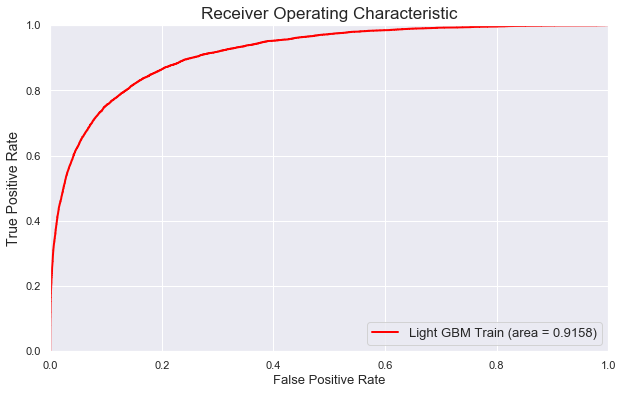

In [574]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

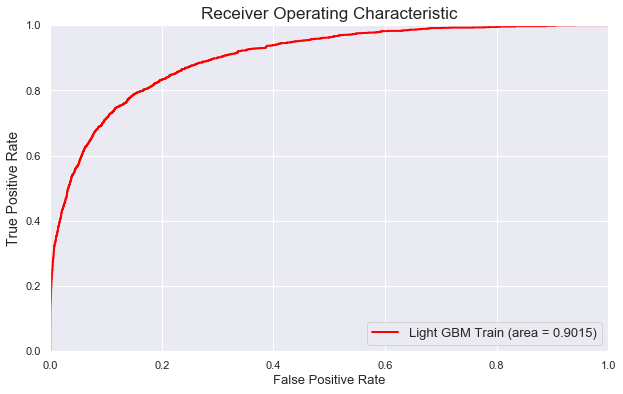

In [575]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [186]:
# #Prediction
# y_pred=clf.predict(X)
# #convert into binary values
# for i in range(0,99):
#     if y_pred[i]>=.4:       # setting threshold to .5
#        y_pred[i]=1
#     else:  
#        y_pred[i]=0

In [187]:
# # predictors = [x for x in X.columns]
# param_test1 = {'n_estimators':range(80,121,10)}
# gsearch1 = GridSearchCV(estimator = LGBMClassifier(learning_rate=0.2, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
# param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(X,y)

In [188]:
# gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [189]:
# gsearch1 = GridSearchCV(estimator = LGBMClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
# param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(X,y)

In [190]:
# param_test2 = {
#  'max_depth':range(5,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch2 = GridSearchCV(estimator = LGBMClassifier( learning_rate=0.2, n_estimators = 90, min_samples_split=500, min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=10), 
# param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch2.fit(X,y)
# gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [191]:
# param_test2 = {
# #  'max_depth':range(5,10,2),
# #  'min_child_weight':range(1,6,2)
#  'max_depth':[4,5,6],
#  'min_child_weight':[4,5,6]
# }
# gsearch2 = GridSearchCV(estimator = LGBMClassifier( learning_rate=0.1, n_estimators = 200, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
# param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch2.fit(X,y)
# gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [192]:
# param_test2 = {
# #  'max_depth':range(5,10,2),
# #  'min_child_weight':range(1,6,2)
# 'gamma':[i/10.0 for i in range(0,5)]
# # }
# }
# gsearch2 = GridSearchCV(estimator = LGBMClassifier( learning_rate=0.1, n_estimators = 200, min_samples_split=500,min_samples_leaf=50,max_depth=5, min_child_weight =5, max_features='sqrt',subsample=0.8,random_state=10), 
# param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch2.fit(X,y)
# gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [193]:
# plot_tree(model)
# fig = plt.gcf()
# fig.set_size_inches(148.5, 130.5)
# plt.show()

In [194]:
# plot_tree(model, num_trees=5)
# fig = plt.gcf()
# fig.set_size_inches(448.5, 130.5)
# plt.show()

In [195]:
# # plot single tree
# fig = plt.figure(dpi=1800)
# ax = plt.subplot(1,1,1)
# plot_tree(model, num_trees= 1, ax = ax)
# plt.tight_layout()
# plt.savefig('tree.png')
# plt.show()

In [481]:
def correlated_features(df):
#     df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
#     df1 = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
#     cat_features = list(df1['Variable Name'].values)
#     for c in cat_features:
#         if c not in df1.columns or c == 'hospital_death':
#             cat_features.remove(c)

#     num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
#     drop_columns=[]
    corr = df.corr()



    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
                    print('col1: {} col2: {} - Correlation: {}'.format(df.columns[i] , df.columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

#     drop_columns = df[num_feature].columns[columns == False].values
#     return drop_columns

In [482]:
correlated_features(X)

col1: diff_ventilated_apache col2: ventilated_apache_1 - Correlation: 1.0
col1: arf_apache_0 col2: intubated_apache_0 - Correlation: 1.0
col1: arf_apache_0 col2: aids_0 - Correlation: 1.0
col1: arf_apache_0 col2: cirrhosis_0 - Correlation: 1.0
col1: arf_apache_0 col2: diabetes_mellitus_0 - Correlation: 1.0
col1: arf_apache_0 col2: hepatic_failure_0 - Correlation: 1.0
col1: arf_apache_0 col2: immunosuppression_0 - Correlation: 1.0
col1: arf_apache_0 col2: leukemia_0 - Correlation: 1.0
col1: arf_apache_0 col2: lymphoma_0 - Correlation: 1.0
col1: arf_apache_0 col2: solid_tumor_with_metastasis_0 - Correlation: 1.0


In [516]:
selected_features.remove('diff_ventilated_apache')

In [517]:
len(selected_features)

179

In [563]:
X.columns

Index(['age', 'albumin_apache', 'almost_dead', 'apache_2_diagnosis',
       'apache_3j_bodysystem_Cardiovascular',
       'apache_3j_bodysystem_Gastrointestinal',
       'apache_3j_bodysystem_Metabolic', 'apache_3j_bodysystem_Neurological',
       'apache_3j_bodysystem_Respiratory', 'apache_3j_bodysystem_Sepsis',
       ...
       'resprate_apache', 'sodium_apache', 'solid_tumor_with_metastasis_1',
       'solid_tumor_with_metastasis_2', 'temp_apache', 'urineoutput_apache',
       'ventilated_apache_1', 'ventilated_apache_2', 'wbc_apache', 'weight'],
      dtype='object', length=179)